# Double-Sided Crystal Ball Signal Fit
This notebook fits the double-sided crystal ball function to the Monte-Carlo simulated signal events. Only pure category 10 and category 50 events are used as these are the 'best' quality signal events. The fit routines will be a least-squares (technically a chi-square as we will include errors) and a maximum likelihood fit.

In [1]:
# Gather the necessary libraries needed
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from utilities import Data, Consts

In [2]:
s = Data(*Consts().get_simulated_tuple())
# Create a data object from the unpacked constant filenames

df = s.fetch_features(['Lb_M', 'Lb_BKGCAT'])
# Get the invariant mass and background category features for all simulated events

df['cat'] = np.where(df['Lb_BKGCAT'].isin([10, 50]), 1, 0)
# Create a category column which is based on the BKGCAT value 1 = signal, 0 = non-signal

df.drop('Lb_BKGCAT', axis=1, inplace=True)
# Now remove the BKGCAT column, it is redundant now

g = df.groupby('cat')
# Group the events by the category (1 or 0)

## Plotting Initial Mass Distribution
Now we will plot the initial mass distribution for the events we care about, that is signal category 1 events. This is just so we know what we are working with. Errors are computed assuming Poisson statistics that is $\sigma\propto\sqrt{N}$.

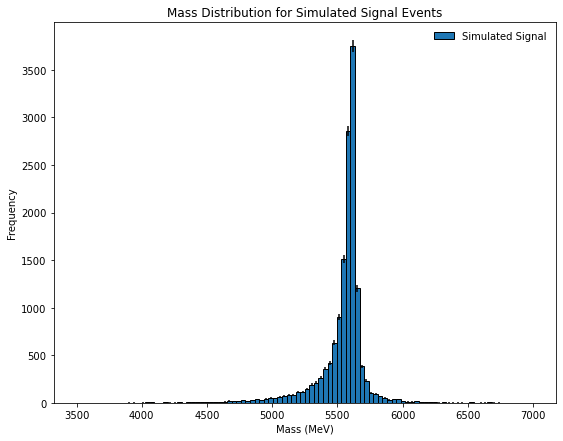

In [3]:
low_mass_limit, high_mass_limit = 3500, 7000
no_bins = 100
bins = np.linspace(low_mass_limit, high_mass_limit, no_bins+1)
# Create an array of bin edges

bin_centres = [np.mean(bins[i:i+2]) for i in range(len(bins)-1)]
bin_width = bins[1]- bins[0]

data = g.get_group(1)[g.get_group(1)['Lb_M'].between(low_mass_limit, high_mass_limit)]

f, _ = np.histogram(g.get_group(1)['Lb_M'], bins=bins)
err = np.sqrt(f)
# The error is the square root of the frequency

d = np.array([bin_centres, f, err]).T
# Make an array of the bin centroid the frequency and the associated error

fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(d[:,0], d[:,1], width=bin_width, yerr=d[:,2], label='Simulated Signal', edgecolor='k', color='#1f77b4')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.title('Mass Distribution for Simulated Signal Events')
plt.legend(frameon=False)
plt.show()

## Fitting the DSCB
Now we have plotted these data we will now attempt to fit them using a statistically sound routine(s). Before fitting we need to remove all the bins with zero frequency and hence zero error.

In [4]:
d = d[d[:,1]!=0,:]
# Remove all the bins with no signal candidates recorded

In [11]:
from scipy.optimize import curve_fit
# For the chi-square fitting routine (least-squares as it is also known)

def dscb(x, mu, sigma, alow, ahigh, nlow, nhigh):
    
    xshift = (x - mu)/sigma
    # Apply a specific function to the shifted values based on initial values
    
    
    
    return 0
    
dscb(d[:,0], *[5600, 30, -0.75, 1.5, 2, 2])

#bounds = ([2800, 5500, 28, -0.85, 1.2, 1, 1], [3000, 5700, 32, -0.65, 1.6, 4, 4])
#popt, pcov = curve_fit(dscb, d[:,0], d[:,1], p0=[2900, 5600, 30, -0.75, 1.36, 2, 2], sigma=d[:,2], bounds=bounds)


[-60.08333333 -56.58333333 -55.41666667 -53.08333333 -51.91666667
 -50.75       -49.58333333 -47.25       -46.08333333 -44.91666667
 -43.75       -42.58333333 -41.41666667 -40.25       -39.08333333
 -37.91666667 -36.75       -35.58333333 -34.41666667 -33.25
 -32.08333333 -30.91666667 -29.75       -28.58333333 -27.41666667
 -26.25       -25.08333333 -23.91666667 -22.75       -21.58333333
 -20.41666667 -19.25       -18.08333333 -16.91666667 -15.75
 -14.58333333 -13.41666667 -12.25       -11.08333333  -9.91666667
  -8.75        -7.58333333  -6.41666667  -5.25        -4.08333333
  -2.91666667  -1.75        -0.58333333   0.58333333   1.75
   2.91666667   4.08333333   5.25         6.41666667   7.58333333
   8.75         9.91666667  11.08333333  12.25        13.41666667
  14.58333333  15.75        16.91666667  18.08333333  19.25
  20.41666667  21.58333333  22.75        23.91666667  25.08333333
  26.25        27.41666667  28.58333333  29.75        30.91666667
  33.25        34.41666667  35.583

0